# Roger Federer Match Length History Pilot Analysis

Now this is exciting ! We will now go beyond analysing generalized (ie. non player specific) match length data and take a look at a specific player : the GOAT Roger Federer. There are several reasons for this choice (many matches at the top level, long career spanning more than two decades, evolution in terms of playstyle) but mainly Federer is my tennis hero.

The goal here is to obtain a series of weighted variables which would allow us to predict the length of a Roger Federer match against a given opponent, under a given set of match conditions.

In [361]:
### IMPORTS ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [362]:
### CLEAN FEDERER MATCHES TABLES ###

atp = pd.read_csv("atp_cat.csv")

fed_won = atp[atp["winner_name"] == "Roger Federer"]    # 1163 wins
fed_lost = atp[atp["loser_name"] == "Roger Federer"]    # 261 loses (82% winrate) (1424 matches total)

# We'll drop all of Federer's information except his age
fed_won = fed_won.drop(labels=["winner_name", "winner_hand", "winner_ht", "winner_ioc"], axis=1)
fed_won = fed_won.rename(columns={"winner_age": "fed_age", "winner_rank": "fed_rank", "winner_rank_points": "fed_rank_points",
                                  "loser_name":"opp_name", "loser_hand":"opp_hand", "loser_ht":"opp_ht", "loser_ioc":"opp_ioc", "loser_age":"opp_age",
                                  "loser_rank": "opp_rank", "loser_rank_points": "opp_rank_points"})
fed_won["fed_won"] = "1"

fed_lost = fed_lost.drop(labels=["loser_name", "loser_hand", "loser_ht", "loser_ioc"], axis=1)
fed_lost = fed_lost.rename(columns={"loser_age": "fed_age", "loser_rank": "fed_rank", "loser_rank_points": "fed_rank_points",
                                    "winner_name":"opp_name", "winner_hand":"opp_hand", "winner_ht":"opp_ht", "winner_ioc":"opp_ioc", "winner_age":"opp_age",
                                    "winner_rank": "opp_rank", "winner_rank_points": "opp_rank_points"})
fed_lost["fed_won"] = "0"

fed = pd.concat([fed_won, fed_lost])
fed = fed.drop("Unnamed: 0", axis=1)
fed = fed.reset_index()

fed.head(5)    # Clean Table of all Roger Federer ATP matches

,index,tourney_name,surface,tourney_level,tourney_date,fed_age,opp_name,opp_hand,opp_ht,opp_ioc,opp_age,score,best_of,round,minutes,fed_rank,fed_rank_points,opp_rank,opp_rank_points,fed_won
0,24932,Toulouse,Hard,A,19980928,17.138946,Guillaume Raoux,R,180.0,FRA,28.618754,6-2 6-2,3,R32,60.0,878.0,9.0,45.0,859.0,1
1,24941,Toulouse,Hard,A,19980928,17.138946,Richard Fromberg,R,196.0,AUS,28.418891,6-1 7-6(5),3,R16,85.0,878.0,9.0,43.0,927.0,1
2,25666,Marseille,Hard,A,19990201,17.483915,Carlos Moya,R,190.0,ESP,22.431211,7-6(1) 3-6 6-3,3,R32,113.0,243.0,173.0,5.0,3178.0,1
3,25682,Marseille,Hard,A,19990201,17.483915,Jerome Golmard,L,188.0,FRA,25.396304,6-7(6) 7-6(5) 7-6(5),3,R16,140.0,243.0,173.0,63.0,743.0,1
4,25849,Rotterdam,Carpet,A,19990215,17.522245,Guillaume Raoux,R,180.0,FRA,29.002053,6-7(4) 7-5 7-6(3),3,R32,149.0,178.0,262.0,71.0,691.0,1


## Simple Regression Decision Tree

We will create a simple decision tree using five features :
- Surface  
- Best of  
- Opponent hand  
- Opponent height  
- Ranking difference  

### Exploration & Visualization

In [363]:
# ATP Colors
# Dark blue : #002865
# Light blue : #00AFF0

In [364]:
# Exemple

fed_surface = pd.pivot_table(fed, values="minutes", index = ["opp_hand"], columns=["surface"]) # average duration per surface
fed_surface

surface,Carpet,Clay,Grass,Hard
opp_hand,,,,
L,61.400000,123.263158,111.172414,92.945652
R,99.153846,103.880165,107.672222,100.138677


C:\Users\uporito\Anaconda3\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\uporito\Anaconda3\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


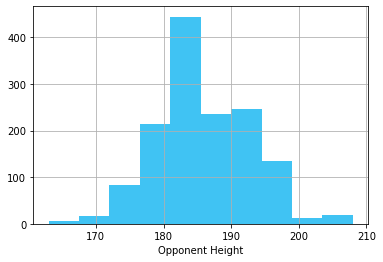

In [365]:
n, bins, patches = plt.hist(fed["opp_ht"], 10, density=False, facecolor='#00AFF0', alpha=0.75)
plt.xlabel('Opponent Height')
plt.ylabel('')
plt.grid(True)
plt.show()

### Formatting

In [366]:
fed1 = fed[["minutes", "surface", "opp_hand", "opp_ht"]]
fed1["rank_diff"] = fed["fed_rank"] - fed["opp_rank"]

# One-Hot Encoding
fed1 = pd.get_dummies(data=fed1, columns=["surface", "opp_hand"])

fed1 = fed1.dropna(axis=0, how='any')

fed1.head(5)

C:\Users\uporito\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,minutes,opp_ht,rank_diff,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,opp_hand_L,opp_hand_R
0,60.0,180.0,833.0,0,0,0,1,0,1
1,85.0,196.0,835.0,0,0,0,1,0,1
2,113.0,190.0,238.0,0,0,0,1,0,1
3,140.0,188.0,180.0,0,0,0,1,1,0
4,149.0,180.0,107.0,1,0,0,0,0,1


### Regression Decision Tree

In [367]:
# PRE-PROCESSING #

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

target='minutes'

# 1. X, y unscaled
X = fed1.drop([target], axis=1)
y = fed1[target]
display(X.head())

# 2. X, y scaled
# X = scale(X)
# y = scale(y)
# display(pd.DataFrame(X).head())

# 3. X scaled, y unscaled
X[['opp_ht','rank_diff']] = scale(X[['opp_ht','rank_diff']])
display(X.head())

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.3)

,opp_ht,rank_diff,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,opp_hand_L,opp_hand_R
0,180.0,833.0,0,0,0,1,0,1
1,196.0,835.0,0,0,0,1,0,1
2,190.0,238.0,0,0,0,1,0,1
3,188.0,180.0,0,0,0,1,1,0
4,180.0,107.0,1,0,0,0,0,1


,opp_ht,rank_diff,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,opp_hand_L,opp_hand_R
0,-0.893796,10.281855,0,0,0,1,0,1
1,1.433962,10.305471,0,0,0,1,0,1
2,0.561053,3.256308,0,0,0,1,0,1
3,0.270083,2.571465,0,0,0,1,1,0
4,-0.893796,1.709507,1,0,0,0,0,1


#### Exemple of Regression Tree

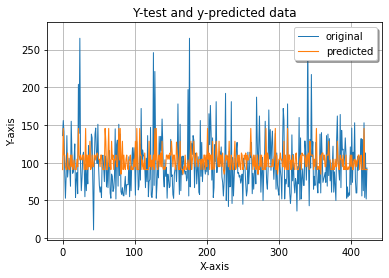

[Text(1016.3571428571429, 733.86, 'rank_diff <= 0.287\nmse = 1740.718\nsamples = 984\nvalue = 104.111'),
 Text(597.8571428571429, 570.78, 'rank_diff <= -0.079\nmse = 1268.129\nsamples = 637\nvalue = 97.662'),
 Text(358.7142857142857, 407.70000000000005, 'surface_Clay <= 0.5\nmse = 1057.185\nsamples = 315\nvalue = 93.949'),
 Text(239.14285714285714, 244.62, 'opp_ht <= 2.671\nmse = 972.861\nsamples = 250\nvalue = 91.428'),
 Text(119.57142857142857, 81.54000000000008, 'mse = 966.996\nsamples = 247\nvalue = 90.992'),
 Text(358.7142857142857, 81.54000000000008, 'mse = 150.889\nsamples = 3\nvalue = 127.333'),
 Text(478.2857142857143, 244.62, 'mse = 1263.029\nsamples = 65\nvalue = 103.646'),
 Text(837.0, 407.70000000000005, 'surface_Grass <= 0.5\nmse = 1447.804\nsamples = 322\nvalue = 101.295'),
 Text(717.4285714285714, 244.62, 'rank_diff <= 0.098\nmse = 1458.757\nsamples = 270\nvalue = 99.048'),
 Text(597.8571428571429, 81.54000000000008, 'mse = 1756.937\nsamples = 116\nvalue = 104.733'),
 T

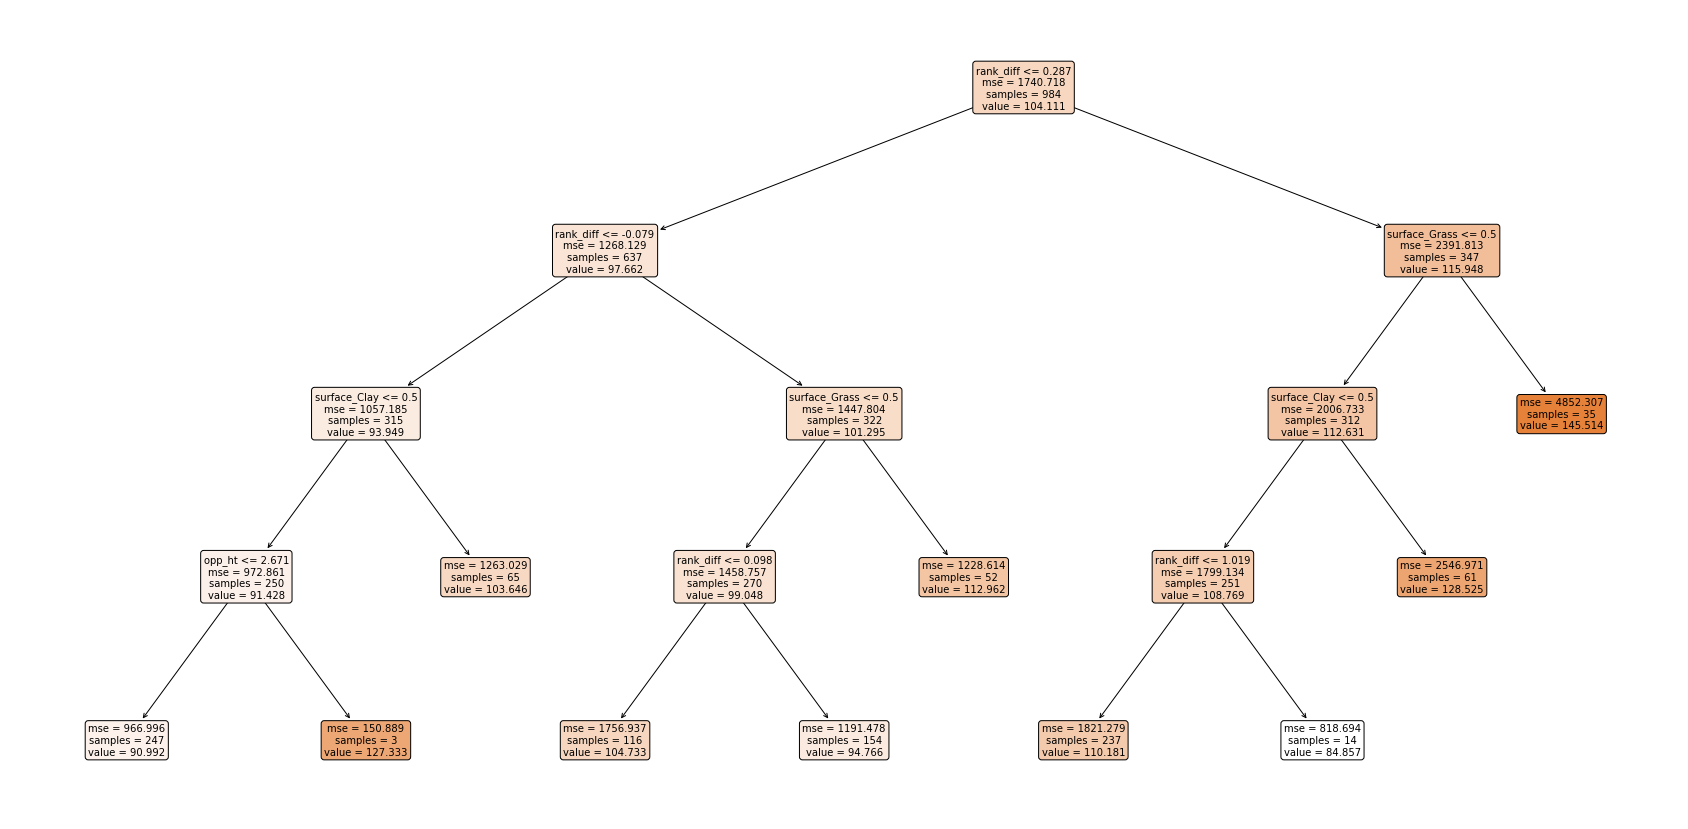

In [368]:
dtr = DecisionTreeRegressor(max_depth=4, min_samples_split=.1)

dtr.fit(Xtrain, ytrain)

ypred = dtr.predict(Xtest)

x_ax = range(len(ytest))
plt.plot(x_ax, ytest, linewidth=1, label="original")
plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
plt.title("Y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

plt.figure(figsize=(30,15))
tree.plot_tree(dtr,
          filled=True,
          rounded=True,
          fontsize=10,
          feature_names=["opp_ht", "rank_diff", "surface_Carpet", "surface_Clay", "surface_Grass", "surface_Hard", "opp_hand_L", "opp_hand_R"])

# plt.savefig('tree_high_dpi', dpi=600)

### Cross Validation

We want to find good values for our parameters and to get an an idea of how our regression trees compare to each other. In order to do that, we will do a K-fold validation, with K = 10.

In [369]:
# Parameters

K = 10

MAX_DEPTH=np.arange(3, 15)
MIN_SAMPLE=[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.075, 0.001]
# MAX_DEPTH=np.arange(3, 5)   # d depths
# MIN_SAMPLE=[0.1]            # s sample ratios

# We will define d x s Regression Trees RT(d,s)

![score formula](res/score.png "sklearn score")

In [376]:
# Basic Error Loop

scores = [[] for n in range(len(MAX_DEPTH))]   # sklearn Decision Tree score (max = 1)
MSE = [[] for n in range(len(MAX_DEPTH))]      # Mean Squared Error
RMSE = [[] for n in range(len(MAX_DEPTH))]     # Root Mean Squared Error

for i in range(len(MAX_DEPTH)) :

    for j in range(len(MIN_SAMPLE)) :

        d = MAX_DEPTH[i]
        s = MIN_SAMPLE[j]

        # print(f"Max depth : {d} , Min sample : {s}")

        dtr = DecisionTreeRegressor(max_depth=d, min_samples_split=s)

        dtr.fit(Xtrain, ytrain)

        score = dtr.score(Xtest, ytest)   
        scores[i].append(score)
        # print(f"score : {score}.")

        Ypred = dtr.predict(Xtest)

        mse = mean_squared_error(ytest, Ypred)  # mean of (y_true - y_pred)**2

        MSE[i].append(mse)
        # print(f"MSE : {mse}.")

scores_df = pd.DataFrame(data=scores, index=MAX_DEPTH, columns=MIN_SAMPLE)
index = scores_df.index
index.name = "scores"
display(scores_df)
MSE_df = pd.DataFrame(data=MSE, index=MAX_DEPTH, columns=MIN_SAMPLE)
index = MSE_df.index
index.name = "MSE"
display(MSE_df)

# Display scores

print("Mean score : ", np.mean(scores))

N = np.argmax(scores)
print(f"Optimal Regressor Tree parameters : d = {MAX_DEPTH[N // len(MIN_SAMPLE)]}, s = {MIN_SAMPLE[N % len(MIN_SAMPLE)]}")
print("Best score : ", scores[N // len(MIN_SAMPLE)][N % len(MIN_SAMPLE)])

,0.500,0.400,0.300,0.200,0.100,0.050,0.075,0.001
scores,,,,,,,,
3,0.036682,0.036682,0.052639,0.052639,0.052639,0.052639,0.052639,0.024972
4,0.036682,0.036682,0.052639,0.056068,0.056068,0.024157,0.056068,-0.023318
5,0.036682,0.036682,0.052639,0.054082,0.051242,0.024247,0.051242,-0.034220
6,0.036682,0.036682,0.052639,0.055370,0.047369,-0.006037,0.047965,-0.128843
7,0.036682,0.036682,0.052639,0.055370,0.032823,-0.031863,0.033418,-0.316323
8,0.036682,0.036682,0.052639,0.055370,0.032240,-0.030837,0.032836,-0.492910
9,0.036682,0.036682,0.052639,0.055370,0.027941,-0.036606,0.028537,-0.584252
10,0.036682,0.036682,0.052639,0.055370,0.028191,-0.036306,0.028836,-0.675537
11,0.036682,0.036682,0.052639,0.055370,0.028191,-0.035070,0.029679,-0.779588


,0.500,0.400,0.300,0.200,0.100,0.050,0.075,0.001
MSE,,,,,,,,
3,1294.812028,1294.812028,1273.363459,1273.363459,1273.363459,1273.363459,1273.363459,1310.551264
4,1294.812028,1294.812028,1273.363459,1268.753909,1268.753909,1311.646289,1268.753909,1375.459018
5,1294.812028,1294.812028,1273.363459,1271.423805,1275.241455,1311.525141,1275.241455,1390.111295
6,1294.812028,1294.812028,1273.363459,1269.693149,1280.447047,1352.231127,1279.646331,1517.295653
7,1294.812028,1294.812028,1273.363459,1269.693149,1299.998892,1386.944220,1299.198176,1769.291390
8,1294.812028,1294.812028,1273.363459,1269.693149,1300.782233,1385.564332,1299.981517,2006.645079
9,1294.812028,1294.812028,1273.363459,1269.693149,1306.560080,1393.318455,1305.759364,2129.418328
10,1294.812028,1294.812028,1273.363459,1269.693149,1306.224843,1392.915882,1305.356791,2252.116279
11,1294.812028,1294.812028,1273.363459,1269.693149,1306.224843,1391.253838,1304.224509,2391.973808


Mean score :  -0.028967206056620103
Optimal Regressor Tree parameters : d = 4, s = 0.2
Best score :  0.05606833448808868


In [371]:
CV = model_selection.KFold(n_splits=K,shuffle=True)

test_errors = [[[]for n in range(len(MIN_SAMPLE))] for n in range(len(MAX_DEPTH))]  # list of K test errors for every RT(d,s) Regression Tree

k=0

for train_index, test_index in CV.split(X, y):
    # Cross-validation loop

    print(f'   K-validation fold: {k+1}/{K}')  
    
    # extract training and test set for current CV fold
    # X_Kj_train = X[train_index,:]
    X_Kj_train = pd.DataFrame(X).iloc[train_index]
    y_Kj_train = pd.Series(y).iloc[train_index]
    # X_Kj_test = X[test_index,:]
    X_Kj_test = pd.DataFrame(X).iloc[test_index]
    y_Kj_test = pd.Series(y).iloc[test_index]

	# Fit and evaluate models
    for i in range(len(MAX_DEPTH)) :

        for j in range(len(MIN_SAMPLE)) :

            d = MAX_DEPTH[i]
            s = MIN_SAMPLE[j]

            # print(f"Max depth : {d} , Min sample : {s}")

            dtr = DecisionTreeRegressor(max_depth=d, min_samples_split=s)

            dtr.fit(X_Kj_train, y_Kj_train)

            score = dtr.score(X_Kj_train, y_Kj_train)   

            Ypred_Kj = dtr.predict(X_Kj_test)

            mse = mean_squared_error(y_Kj_test, Ypred_Kj)
            test_errors[i][j].append(mse)

    k+=1

# print("[Test errors] :")
# print(test_errors)
gen_error = np.sum(test_errors, axis=2)
print("[Generalized errors] :")
display(pd.DataFrame(gen_error))
N = np.argmin(gen_error)
print(f"Optimal Regressor Tree parameters : d = {MAX_DEPTH[N // len(MIN_SAMPLE)]}, s = {MIN_SAMPLE[N % len(MIN_SAMPLE)]}")

   K-validation fold: 1/10
   K-validation fold: 2/10
   K-validation fold: 3/10
   K-validation fold: 4/10
   K-validation fold: 5/10
   K-validation fold: 6/10
   K-validation fold: 7/10
   K-validation fold: 8/10
   K-validation fold: 9/10
   K-validation fold: 10/10
[Generalized errors] :


,0,1,2,3,4,5,6,7
0,15725.844592,15799.537607,15625.282426,15527.615988,15721.892811,15716.129741,15716.129741,15702.819440
1,15727.106522,15800.799537,15644.852192,15433.828941,15550.409332,15555.757419,15510.732234,15706.556263
2,15727.106522,15800.799537,15665.143410,15545.478087,15685.806779,15951.512855,15602.562625,16329.909848
3,15727.106522,15800.799537,15665.143410,15446.755084,15702.750744,16048.045884,15633.888867,17052.503039
4,15727.106522,15800.799537,15665.143410,15446.755084,15949.124206,16361.108505,15920.818332,18157.946758
5,15727.106522,15800.799537,15665.143410,15446.755084,16015.419268,16506.027050,15994.885503,19300.972384
6,15727.106522,15800.799537,15665.143410,15446.755084,16028.295987,16534.385053,15980.199532,20811.000241
7,15727.106522,15800.799537,15665.143410,15446.755084,16154.580525,16699.182471,16103.019283,22356.410610
8,15727.106522,15800.799537,15665.143410,15446.755084,16192.525832,16803.626620,16142.567085,23615.648336
9,15727.106522,15800.799537,15665.143410,15446.755084,16204.330866,16811.858409,16147.167644,24576.199829


Optimal Regressor Tree parameters : d = 4, s = 0.2


### Conclusion

Here are the best scores for the 3 different pre-processing options :

x,y scaled : -0.020589155340231615  
x,y unscaled : -0.05225712006153819  
x scaled, y unscaled : -0.07087680978321888